In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(font_scale=1.25)
plt.rcParams["figure.figsize"] = [8, 6]

In [59]:
data = pd.read_csv('timings_agg_revision.csv')
categories = pd.read_csv("../../2phase_nsa/categories/statsceb_categories.csv")[["query","well_behaved"]].set_index("query")
data = pd.merge(data, categories, left_on="query", right_index=True, how="outer")
data

/home/liese/.local/lib/python3.10/site-packages/IPython/lib/pretty.py:778: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output = repr(obj)
/home/liese/.local/lib/python3.10/site-packages/IPython/core/formatters.py:342: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  return method()


,query,method,total_time,execution_time,hashjoin_time,well_behaved
0,1,DF-Bin,NaN,0.001469,0.001131,True
143,1,SYA,NaN,0.001255,0.000927,True
286,1,DuckDB-Bin,0.000946,0.000632,0.000481,True
429,1,Umbra-Default,0.021876,0.002226,NaN,True
575,1,Umbra-L&E,0.070066,0.001236,NaN,True
...,...,...,...,...,...,...
694,120,Umbra-L&E,8.177798,8.145830,NaN,NaN
983,120,Umbra-Chained,32.637184,32.617700,NaN,NaN
550,122,Umbra-Default,37.154403,37.123400,NaN,NaN
696,122,Umbra-L&E,8.545841,8.512860,NaN,NaN


In [60]:
# Create one table for each method
df_bin = data[data["method"] == "DF-Bin"].drop(columns=["method"]).set_index("query")
sya = data[data["method"] == "SYA"].drop(columns=["method"]).set_index("query") 
duckdb_bin = data[data["method"] == "DuckDB-Bin"].drop(columns=["method"]).set_index("query") 
umbra_default = data[data["method"] == "Umbra-Default"].drop(columns=["method"]).set_index("query")
umbra_le = data[data["method"] == "Umbra-L&E"].drop(columns=["method"]).set_index("query")

In [61]:
joinmethod = "outer"
merged = pd.merge(
                pd.merge(
                    pd.merge(
                        pd.merge(duckdb_bin,df_bin, on="query", suffixes=("_duckdbbin", "_dfbin"), how=joinmethod),
                        sya.add_suffix("_sya"), on="query", how=joinmethod
                    ),
                    umbra_default.add_suffix("_umbra_default"), on="query", how=joinmethod
                ), 
                umbra_le.add_suffix("_umbra_le"), on="query", how=joinmethod
            ).drop(columns=["well_behaved_duckdbbin", "well_behaved_dfbin","well_behaved_umbra_default","well_behaved_umbra_le"]).rename(columns={"well_behaved_sya": "well_behaved"})
merged

,total_time_duckdbbin,execution_time_duckdbbin,hashjoin_time_duckdbbin,total_time_dfbin,execution_time_dfbin,hashjoin_time_dfbin,total_time_sya,execution_time_sya,hashjoin_time_sya,well_behaved,total_time_umbra_default,execution_time_umbra_default,hashjoin_time_umbra_default,total_time_umbra_le,execution_time_umbra_le,hashjoin_time_umbra_le
query,,,,,,,,,,,,,,,,
1,0.000946,0.000632,0.000481,NaN,0.001469,0.001131,NaN,0.001255,0.000927,True,0.021876,0.002226,NaN,0.070066,0.001236,NaN
2,0.179120,0.161075,0.158730,NaN,0.142300,0.138718,NaN,0.020380,0.017348,True,0.069199,0.050874,NaN,0.026795,0.010660,NaN
3,0.119165,0.107446,0.105548,NaN,0.026375,0.021824,NaN,0.008881,0.004409,True,0.029784,0.009855,NaN,0.019424,0.003403,NaN
4,0.019324,0.017426,0.015609,NaN,0.024219,0.018898,NaN,0.010474,0.005204,True,0.030730,0.011896,NaN,0.019851,0.004043,NaN
5,0.446259,0.406639,0.404052,NaN,0.089819,0.085666,NaN,0.017128,0.013241,True,0.053665,0.033748,NaN,0.023311,0.007563,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,0.046936,0.042258,0.036962,NaN,0.018423,0.011213,NaN,0.015764,0.008657,False,0.053164,0.005951,NaN,0.053346,0.002722,NaN
146,0.073504,0.065243,0.061035,NaN,0.035033,0.025247,NaN,0.039915,0.030202,False,0.053810,0.009824,NaN,0.054584,0.004544,NaN
58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,58.902085,58.858000,NaN,8.820404,8.770750,NaN


In [70]:
def scatterplot(data, x, y, label_col: str|None = None, min=1e-4, max=1e1):
    if label_col is not None:
        ax = sns.scatterplot(data, x=x, y=y, hue=data[label_col],palette={False:"tab:orange", True:"tab:blue"})
    else:
        ax = sns.scatterplot(data, x=x, y=y, color="b")
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.plot([min, max], [min, max], color='grey', linestyle='-', alpha=0.5)
    return ax

def print_speedups(data: pd.DataFrame, x: str, y: str):
    speedups = data[x] / data[y]
    print("Avg. speedup:       {:.3f}x".format(speedups.mean()))
    print("Median speedup:     {:.3f}x".format(speedups.median()))
    abs_speedups = data[x] - data[y]
    print("Avg. abs. speedup:       {:.3f}s".format(abs_speedups.mean()))
    print("Median abs. speedup:     {:.3f}s".format(abs_speedups.median()))
    max_slowdown = (data[y] / data[x]).max()
    max_slowdown_query = data[data[y] / data[x] == max_slowdown].index[0]
    x_time = data.loc[max_slowdown_query, x]
    y_time = data.loc[max_slowdown_query, y]
    print("Max. slowdown:      {:.3f}x \t(query {:s}, x={:.3f}s, y={:.3f}s)".format(max_slowdown, str(max_slowdown_query), x_time, y_time))

    max_abs_slowdown = (data[y] - data[x]).max()
    max_abs_slowdown_query = data[(data[y] - data[x]) == max_abs_slowdown].index[0]
    x_time = data.loc[max_abs_slowdown_query, x]
    y_time = data.loc[max_abs_slowdown_query, y]
    print("Max. abs. slowdown: {:.3f}s \t(query {:s}, x={:.3f}s, y={:.3f}s)".format(max_abs_slowdown, str(max_abs_slowdown_query), x_time, y_time))

    max_speedup = (data[x] / data[y]).max()
    max_speedup_query = data[data[x] / data[y] == max_speedup].index[0]
    x_time = data.loc[max_speedup_query, x]
    y_time = data.loc[max_speedup_query, y]
    print("Max. speedup:       {:.3f}x \t(query {:s}, x={:.3f}s, y={:.3f}s)".format(max_speedup, str(max_speedup_query), x_time, y_time))

    max_abs_speedup = (data[x] - data[y]).max()
    max_abs_speedup_query = data[(data[x] - data[y]) == max_abs_speedup].index[0]
    x_time = data.loc[max_abs_speedup_query, x]
    y_time = data.loc[max_abs_speedup_query, y]
    print("Max. abs. speedup:  {:.3f}s \t(query {:s}, x={:.3f}s, y={:.3f}s)".format(max_abs_speedup, str(max_abs_speedup_query), x_time, y_time))
    print("-----------------------------------------------")

def print_stats(ratio_col: pd.Series, epsilon: float = 0.01):
    ratio_col.dropna(inplace=True)
    n_rows = len(ratio_col)
    n_above = ratio_col[ratio_col > 1+epsilon].shape[0]
    n_below = ratio_col[ratio_col < 1-epsilon].shape[0]
    n_equal = ratio_col[(ratio_col >= 1-epsilon) & (ratio_col <= 1+epsilon)].shape[0]

    print(f"Total: {n_rows}, epsilon: {epsilon}")
    print("Number of dots above the line:", n_above, f"({n_above/n_rows*100:.2f}%)")
    print("Number of dots below the line:", n_below , f"({n_below/n_rows*100:.2f}%)")
    print("Number of dots on the line", n_equal, f"({n_equal/n_rows*100:.2f}%)")

## DuckDB vs DataFusion

In [71]:
x = "hashjoin_time_duckdbbin"
y = "hashjoin_time_dfbin"

print_speedups(merged, x, y)
print_stats(ratio_col = merged[y] / merged[x])
# scatterplot(merged, x, y, "well_behaved", min=1e-4, max=1e3)
merged[[x,y]].dropna().to_csv("statsceb_jointime_duckdbbin_vs_dfbin.dat", sep=" ", header=True, index=True)

Avg. speedup:       2.805x
Median speedup:     2.142x
Avg. abs. speedup:       2.930s
Median abs. speedup:     0.027s
Max. slowdown:      3.225x 	(query 28, x=0.238s, y=0.767s)
Max. abs. slowdown: 0.529s 	(query 28, x=0.238s, y=0.767s)
Max. speedup:       13.714x 	(query 59, x=19.188s, y=1.399s)
Max. abs. speedup:  159.143s 	(query 126, x=201.821s, y=42.678s)
-----------------------------------------------
Total: 143, epsilon: 0.01
Number of dots above the line: 24 (16.78%)
Number of dots below the line: 115 (80.42%)
Number of dots on the line 4 (2.80%)


In [72]:
x = "execution_time_duckdbbin"
y = "execution_time_dfbin"

print_speedups(merged, x, y)
print_stats(ratio_col = merged[y] / merged[x])
# scatterplot(merged, x, y, "well_behaved", min=1e-4, max=1e3)
merged[[x,y]].dropna().to_csv("statsceb_executiontime_duckdbbin_vs_dfbin.dat", sep=" ", header=True, index=True)

Avg. speedup:       2.379x
Median speedup:     1.479x
Avg. abs. speedup:       2.931s
Median abs. speedup:     0.024s
Max. slowdown:      3.384x 	(query 20, x=0.003s, y=0.011s)
Max. abs. slowdown: 0.525s 	(query 28, x=0.248s, y=0.773s)
Max. speedup:       13.522x 	(query 59, x=19.197s, y=1.420s)
Max. abs. speedup:  158.949s 	(query 126, x=201.980s, y=43.031s)
-----------------------------------------------
Total: 143, epsilon: 0.01
Number of dots above the line: 40 (27.97%)
Number of dots below the line: 98 (68.53%)
Number of dots on the line 5 (3.50%)


## DF-Bin v.s. SYA

Avg. speedup:       3.664x
Median speedup:     2.455x
Avg. abs. speedup:       0.961s
Median abs. speedup:     0.013s
Max. slowdown:      1.370x 	(query 54, x=0.002s, y=0.002s)
Max. abs. slowdown: 0.005s 	(query 146, x=0.025s, y=0.030s)
Max. speedup:       29.005x 	(query 49, x=0.966s, y=0.033s)
Max. abs. speedup:  37.145s 	(query 126, x=42.678s, y=5.533s)
-----------------------------------------------
Total: 143, epsilon: 0.01
Number of dots above the line: 8 (5.59%)
Number of dots below the line: 133 (93.01%)
Number of dots on the line 2 (1.40%)


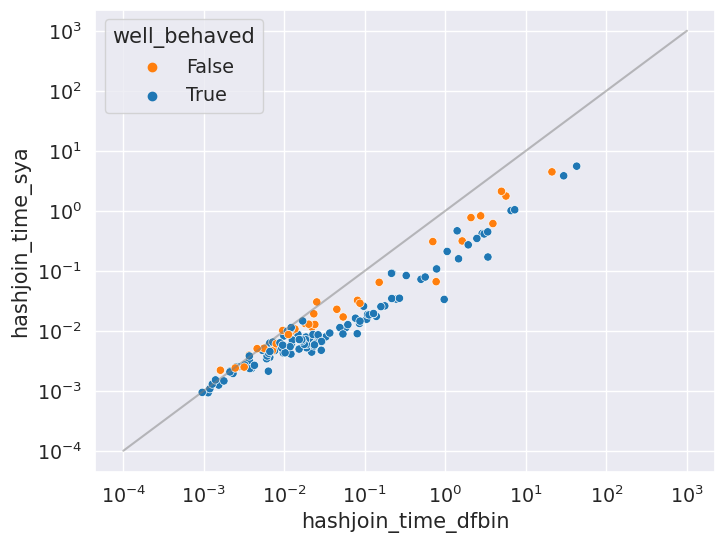

In [73]:
x = "hashjoin_time_dfbin"
y = "hashjoin_time_sya"

print_speedups(merged, x, y)
print_stats(ratio_col = merged[y] / merged[x])
scatterplot(merged, x, y, label_col="well_behaved", min=1e-4, max=1e3)
merged[[x,y,"well_behaved"]].dropna().to_csv("statsceb_jointime_dfbin_vs_sya.dat", sep=" ", header=True, index=True)

Avg. speedup:       3.134x
Median speedup:     2.071x
Avg. abs. speedup:       0.966s
Median abs. speedup:     0.013s
Max. slowdown:      1.154x 	(query 54, x=0.004s, y=0.005s)
Max. abs. slowdown: 0.005s 	(query 146, x=0.035s, y=0.040s)
Max. speedup:       23.970x 	(query 49, x=0.974s, y=0.041s)
Max. abs. speedup:  37.433s 	(query 126, x=43.031s, y=5.598s)
-----------------------------------------------
Total: 143, epsilon: 0.01
Number of dots above the line: 8 (5.59%)
Number of dots below the line: 132 (92.31%)
Number of dots on the line 3 (2.10%)


<Axes: xlabel='execution_time_dfbin', ylabel='execution_time_sya'>

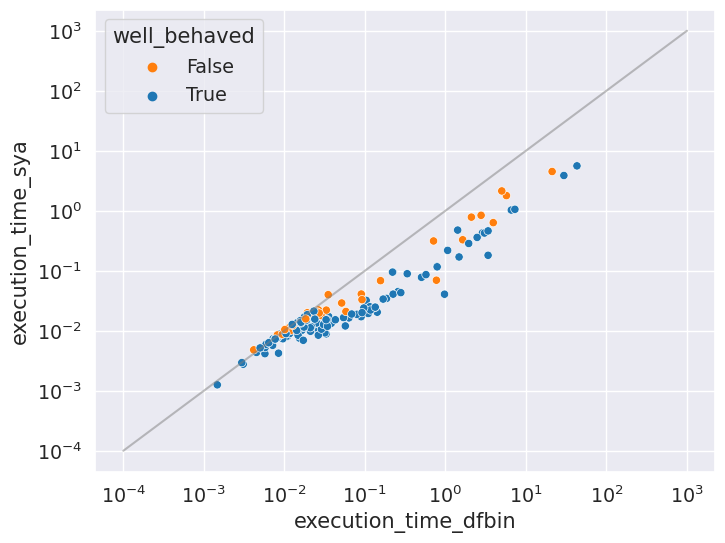

In [74]:
x = "execution_time_dfbin"
y = "execution_time_sya"

print_speedups(merged, x, y)
print_stats(ratio_col = merged[y] / merged[x])
scatterplot(merged, x, y, label_col="well_behaved", min=1e-4, max=1e3)

In [75]:
x = "execution_time_dfbin"
y = "execution_time_sya"

tmp = merged[merged["well_behaved"] ==  True]
print_speedups(tmp, x, y)
print_stats(ratio_col = tmp[y] / tmp[x])
# scatterplot(tmp, x, y, "well_behaved")

Avg. speedup:       3.378x
Median speedup:     2.153x
Avg. abs. speedup:       0.950s
Median abs. speedup:     0.014s
Max. slowdown:      1.035x 	(query 57, x=0.005s, y=0.005s)
Max. abs. slowdown: 0.000s 	(query 134, x=0.013s, y=0.013s)
Max. speedup:       23.970x 	(query 49, x=0.974s, y=0.041s)
Max. abs. speedup:  37.433s 	(query 126, x=43.031s, y=5.598s)
-----------------------------------------------
Total: 111, epsilon: 0.01
Number of dots above the line: 3 (2.70%)
Number of dots below the line: 105 (94.59%)
Number of dots on the line 3 (2.70%)


In [76]:
x = "execution_time_dfbin"
y = "execution_time_sya"

tmp = merged[merged["well_behaved"] ==  False]
print_speedups(tmp, x, y)
print_stats(ratio_col = tmp[y] / tmp[x])
# scatterplot(tmp, x, y, "well_behaved")

Avg. speedup:       2.286x
Median speedup:     1.438x
Avg. abs. speedup:       1.022s
Median abs. speedup:     0.009s
Max. slowdown:      1.154x 	(query 54, x=0.004s, y=0.005s)
Max. abs. slowdown: 0.005s 	(query 146, x=0.035s, y=0.040s)
Max. speedup:       11.112x 	(query 28, x=0.773s, y=0.070s)
Max. abs. speedup:  16.644s 	(query 68, x=21.150s, y=4.507s)
-----------------------------------------------
Total: 32, epsilon: 0.01
Number of dots above the line: 5 (15.62%)
Number of dots below the line: 27 (84.38%)
Number of dots on the line 0 (0.00%)


# Umbra-L&E (or SYA) speedup


In [77]:
# inner join all methods
# (only consider queries that are run by all methods)
tmp = pd.merge(
    pd.merge(
    pd.merge(sya, df_bin, on="query", suffixes=("_sya", "_dfbin"), how="inner"),
    umbra_le.add_suffix("_umbra_le"), on="query", how="inner"
),
umbra_default.add_suffix("_umbra_default"), on="query", how="inner"
).rename(columns={"well_behaved_sya": "well_behaved"})

x = "execution_time_umbra_default"
y = "execution_time_umbra_le"

print_speedups(tmp, x, y)

Avg. speedup:       2.866x
Median speedup:     2.619x
Avg. abs. speedup:       0.146s
Median abs. speedup:     0.006s
Max. slowdown:      0.821x 	(query 41, x=0.000s, y=0.000s)
Max. abs. slowdown: -0.000s 	(query 41, x=0.000s, y=0.000s)
Max. speedup:       19.086x 	(query 106, x=0.051s, y=0.003s)
Max. abs. speedup:  5.579s 	(query 135, x=7.448s, y=1.869s)
-----------------------------------------------
